In [216]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SolveLinSys
from numba import njit
from derivative import derivatives_2d

PDE:

\begin{align*}
0 = \max_{\tilde{e}} \min_{\pi_i^c, \sum_{i=1}^n \pi^c_i=1} & b \delta \eta \log \tilde{e} + b(\eta-1)\left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right] \tilde{e}  \sum_{i=1}^n \pi^a_i \theta_i\\
& + \frac{\partial V}{\partial y}\tilde{e} \sum_{i=1}^n \pi^a_i \theta_i - b \delta \frac{\partial V}{\partial b}\\
& + \frac{1}{2}\frac{\partial^2 V}{(\partial y)^2}|\sigma_y|^2(\tilde{e})^2 - \ell \tilde{e}\\
& + b(\eta-1)\left[\frac{1}{2}\left(\gamma_2 + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}\right)\right]|\sigma_y|^2(\tilde{e})^2\\
&  + \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)\\
\end{align*}

The FOC of $\tilde{e}$ gives:

$$
\tilde{e}^* = \frac{-\left[ G(y)\sum_{i=1}^n \pi^c_i - \ell\right] - \sqrt{\left[ G(y)\sum_{i=1}^n \pi^c_i - \ell\right]^2-4b\delta \eta |\sigma_y|^2F(y)}}{2|\sigma_y|^2F(y)}
$$

where $G(y):=\frac{\partial V}{\partial y} + b(\eta-1)\left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right]$, $F(y):=\frac{\partial^2 V}{(\partial y)^2} + b(\eta-1)\left(\gamma_2 + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}\right)$.

In addition, the FOC of $\pi^a$ gives:
$$
\pi_i^c \propto \exp \left[-\frac{1}{\xi_a}G(y)\tilde{e}\theta_i\right]\hat{\pi}^a_i
$$

In [217]:
def false_transient_one_iteration(stateSpace, A, B_y, B_b, C_yy, C_bb, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_y.reshape(-1, 1, order='F'), B_b.reshape(-1, 1, order='F')])
    C = np.hstack([C_yy.reshape(-1, 1, order='F'), C_bb.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out

In [230]:
def false_transient(y_grid, b_grid, ell, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000, print_all=True):
    η, δ, θ, πc_o, ξ_a, σ_y, γ_1, γ_2, γ_2p, y_bar = model_paras
    Δ_y = y_grid[1] - y_grid[0]
    Δ_b = b_grid[1] - b_grid[0]
    (y_mat, b_mat) = np.meshgrid(y_grid, b_grid, indexing = 'ij')
    stateSpace = np.hstack([y_mat.reshape(-1, 1, order='F'), b_mat.reshape(-1, 1, order='F')])    

    if v0 is None:
        v0 = -δ*η*(y_mat+y_mat**2)

    d_Λ = γ_1 + γ_2*y_mat + γ_2p*(y_mat>y_bar)*(y_mat-y_bar)
    dd_Λ = γ_2 + γ_2p*(y_mat>y_bar)

    πc = np.ones((len(πc_o), len(y_grid), len(b_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape    

    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()

        v0_dy = derivatives_2d(v0, 0, 1, Δ_y)
        v0_dyy = derivatives_2d(v0, 0, 2, Δ_y)
        v0_db = derivatives_2d(v0, 1, 1, Δ_b)

        G = v0_dy + b_mat*(η-1)*d_Λ

        if σ_y == 0:
            e_tilde = -b_mat*δ*η/(G*np.sum(πc*θ, axis=0)-ell)
        else:
            temp = σ_y**2*(v0_dyy+b_mat*(η-1.)*dd_Λ)
            root = (np.sum(πc*θ, axis=0)*G - ell)**2 - 4*b_mat*δ*η*temp
            root[root<0] = 0.
            e_tilde = (-(G*np.sum(πc*θ, axis=0)-ell) - np.sqrt(root)) / (2*temp)
        e_tilde[e_tilde<=0] = 1e-16

        log_πc_ratio = -G*e_tilde*np.sum(πc*θ, axis=0)/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)        

        A = np.zeros_like(y_mat)
        B_y = e_tilde * np.sum(πc*θ, axis=0)
        B_b = -b_mat*δ
        C_yy = .5 * σ_y**2 * e_tilde**2
        C_bb = np.zeros_like(y_mat)
        D = b_mat*δ*η*np.log(e_tilde) + b_mat*(η-1)*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            + .5*b_mat*(η-1)*dd_Λ*σ_y**2*e_tilde**2 - ell*e_tilde\
            + ξ_a * c_entropy
        res = false_transient_one_iteration(stateSpace, A, B_y, B_b, C_yy, C_bb, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_y*v0_dy + B_b*v0_db + C_yy*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,}
    return res

In [232]:
ξ_a = 1000.

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
# γ_2p = .0197*2*.5 # weighted model of low and high
γ_2p = 0. # low damage model

n_y = 100
y_min = 0.
y_max = 4.
y_grid = np.linspace(y_min, y_max, n_y)

n_b = 100
b_min = 1./n_b
b_max = 1.
b_grid = np.linspace(b_min, b_max, n_b)

model_paras = (η, δ, θ, πc_o, ξ_a, σ_y, γ_1, γ_2, γ_2p, y_bar) 

ell = 1e-7
ell_step = ell/100.

model_res = false_transient(y_grid, b_grid, ell, model_paras=model_paras, v0=None, ϵ=1.,
                            tol=1e-6, max_iter=1_000, print_all=False)
model_res_right = false_transient(y_grid, b_grid, ell+ell_step, model_paras=model_paras, v0=None, ϵ=1.,
                            tol=1e-6, max_iter=1_000, print_all=False)

Iteration 1: LHS Error: 0.0011430675525912857; RHS Error 0.0012482193350657196
Iteration 2: LHS Error: 0.001069848714518547; RHS Error 0.0011485920166854323
Iteration 3: LHS Error: 0.0010126773955990188; RHS Error 0.0010738156030654811
Iteration 4: LHS Error: 0.0009657238485610881; RHS Error 0.001015269886979272
Iteration 5: LHS Error: 0.0009258591270282501; RHS Error 0.0009674559542091507
Iteration 6: LHS Error: 0.0008911784536143963; RHS Error 0.000927066028725857
Iteration 7: LHS Error: 0.0008604353985774043; RHS Error 0.0008920533204697268
Iteration 8: LHS Error: 0.0008327754668584209; RHS Error 0.0008610912610585917
Iteration 9: LHS Error: 0.0008075913117984394; RHS Error 0.0008332811545503076
Iteration 10: LHS Error: 0.0007844380339125379; RHS Error 0.0008079905143943166
Iteration 11: LHS Error: 0.000762981173032206; RHS Error 0.0007847594783673365
Iteration 12: LHS Error: 0.0007429636370446264; RHS Error 0.0007632444184450247
Iteration 13: LHS Error: 0.000724183900446462; RHS Er

Iteration 106: LHS Error: 0.0001473898739031837; RHS Error 0.0001497327806936463
Iteration 107: LHS Error: 0.0001450823892482772; RHS Error 0.00014739047798841486
Iteration 108: LHS Error: 0.00014280911481243802; RHS Error 0.00014508297568123366
Iteration 109: LHS Error: 0.00014056947658882407; RHS Error 0.00014280968354810737
Iteration 110: LHS Error: 0.000138362911138383; RHS Error 0.00014057002398481773
Iteration 111: LHS Error: 0.00013618887657760453; RHS Error 0.00013836344328538623
Iteration 112: LHS Error: 0.0001340468279365445; RHS Error 0.00013618938354204566
Iteration 113: LHS Error: 0.00013193625006952675; RHS Error 0.00013404732107698204
Iteration 114: LHS Error: 0.00012985662484879534; RHS Error 0.00013193672568037888
Iteration 115: LHS Error: 0.000127807452197988; RHS Error 0.0001298570888238346
Iteration 116: LHS Error: 0.00012578823134024725; RHS Error 0.00012780789360211208
Iteration 117: LHS Error: 0.00012379849074043575; RHS Error 0.0001257886623066822
Iteration 118:

Iteration 213: LHS Error: 2.1363564064819096e-05; RHS Error 2.1853948427808466e-05
Iteration 214: LHS Error: 2.088065672360001e-05; RHS Error 2.1363591814964485e-05
Iteration 215: LHS Error: 2.0405098138887023e-05; RHS Error 2.0880674928870418e-05
Iteration 216: LHS Error: 1.9936799237563196e-05; RHS Error 2.0405121914582303e-05
Iteration 217: LHS Error: 1.9475661149966073e-05; RHS Error 1.9936821495588155e-05
Iteration 218: LHS Error: 1.902158850677904e-05; RHS Error 1.947568101760334e-05
Iteration 219: LHS Error: 1.857448839978626e-05; RHS Error 1.9021609552838034e-05
Iteration 220: LHS Error: 1.8134268020914002e-05; RHS Error 1.8574505311065603e-05
Iteration 221: LHS Error: 1.770083916621812e-05; RHS Error 1.8134286141003307e-05
Iteration 222: LHS Error: 1.7274113784354617e-05; RHS Error 1.7700862108972586e-05
Iteration 223: LHS Error: 1.685399700553092e-05; RHS Error 1.7274132606162878e-05
Iteration 224: LHS Error: 1.6440403097763012e-05; RHS Error 1.6854014387157655e-05
Iteration 

Iteration 314: LHS Error: 5.605809261773585e-06; RHS Error 5.603442312854576e-06
Iteration 315: LHS Error: 5.60837121836924e-06; RHS Error 5.605809453257594e-06
Iteration 316: LHS Error: 5.610821638398454e-06; RHS Error 5.608371679280064e-06
Iteration 317: LHS Error: 5.613248222755517e-06; RHS Error 5.610822346224721e-06
Iteration 318: LHS Error: 5.615814262038485e-06; RHS Error 5.613248934351419e-06
Iteration 319: LHS Error: 5.6182898847748075e-06; RHS Error 5.6158151752773704e-06
Iteration 320: LHS Error: 5.620733053958264e-06; RHS Error 5.618290932069329e-06
Iteration 321: LHS Error: 5.623323541063471e-06; RHS Error 5.620734107383434e-06
Iteration 322: LHS Error: 5.625839435709733e-06; RHS Error 5.6233735107138235e-06
Iteration 323: LHS Error: 5.628293694838124e-06; RHS Error 5.6260253831769006e-06
Iteration 324: LHS Error: 5.63088575245875e-06; RHS Error 5.628622216825624e-06
Iteration 325: LHS Error: 5.633454534340401e-06; RHS Error 5.6313785742091184e-06
Iteration 326: LHS Error:

Iteration 418: LHS Error: 5.490243611072643e-06; RHS Error 6.55025357835582e-06
Iteration 419: LHS Error: 5.48129683040216e-06; RHS Error 6.548695006517282e-06
Iteration 420: LHS Error: 5.472283424651225e-06; RHS Error 6.546961778233621e-06
Iteration 421: LHS Error: 5.463207156660571e-06; RHS Error 6.545052417459424e-06
Iteration 422: LHS Error: 5.454071428129259e-06; RHS Error 6.542988900785701e-06
Iteration 423: LHS Error: 5.444879456233814e-06; RHS Error 6.540753371592732e-06
Iteration 424: LHS Error: 5.435635319451376e-06; RHS Error 6.538373900010397e-06
Iteration 425: LHS Error: 5.426342238538939e-06; RHS Error 6.535835647833378e-06
Iteration 426: LHS Error: 5.417003986468022e-06; RHS Error 6.5331526645585935e-06
Iteration 427: LHS Error: 5.4076234964652026e-06; RHS Error 6.530324911510816e-06
Iteration 428: LHS Error: 5.398203787441991e-06; RHS Error 6.527370242330813e-06
Iteration 429: LHS Error: 5.388747814725342e-06; RHS Error 6.5242757160343615e-06
Iteration 430: LHS Error: 5

Iteration 526: LHS Error: 4.5826467879248045e-06; RHS Error 6.034304904212477e-06
Iteration 527: LHS Error: 4.577547261123971e-06; RHS Error 6.02967217804614e-06
Iteration 528: LHS Error: 4.572486622576866e-06; RHS Error 6.025065041534005e-06
Iteration 529: LHS Error: 4.567472267770489e-06; RHS Error 6.020491117131256e-06
Iteration 530: LHS Error: 4.562494690510399e-06; RHS Error 6.015945472596213e-06
Iteration 531: LHS Error: 4.557566465501761e-06; RHS Error 6.011431106938011e-06
Iteration 532: LHS Error: 4.552671885871273e-06; RHS Error 6.006943471780651e-06
Iteration 533: LHS Error: 4.547822683317881e-06; RHS Error 6.002481080249599e-06
Iteration 534: LHS Error: 4.5430149127195785e-06; RHS Error 5.998057871417191e-06
Iteration 535: LHS Error: 4.5382401936619465e-06; RHS Error 5.993661737790142e-06
Iteration 536: LHS Error: 4.533515561150336e-06; RHS Error 5.9892940425362775e-06
Iteration 537: LHS Error: 4.528823292798689e-06; RHS Error 5.9849509232272075e-06
Iteration 538: LHS Error

Iteration 631: LHS Error: 4.230555453982321e-06; RHS Error 5.699577748774238e-06
Iteration 632: LHS Error: 4.228570372626084e-06; RHS Error 5.6976450062156845e-06
Iteration 633: LHS Error: 4.226601879091241e-06; RHS Error 5.695721307545816e-06
Iteration 634: LHS Error: 4.224656100511315e-06; RHS Error 5.693816355821458e-06
Iteration 635: LHS Error: 4.222727880455468e-06; RHS Error 5.6919308944492495e-06
Iteration 636: LHS Error: 4.2208211701033616e-06; RHS Error 5.690064863658317e-06
Iteration 637: LHS Error: 4.218929042384967e-06; RHS Error 5.688221727060869e-06
Iteration 638: LHS Error: 4.21705906188119e-06; RHS Error 5.6863857001557055e-06
Iteration 639: LHS Error: 4.215205631860619e-06; RHS Error 5.684569533207428e-06
Iteration 640: LHS Error: 4.213368120641048e-06; RHS Error 5.682772366105769e-06
Iteration 641: LHS Error: 4.211546889704154e-06; RHS Error 5.680992475220808e-06
Iteration 642: LHS Error: 4.209743126232235e-06; RHS Error 5.679226164007848e-06
Iteration 643: LHS Error:

Iteration 736: LHS Error: 4.099034625192066e-06; RHS Error 5.571486459613807e-06
Iteration 737: LHS Error: 4.0983173291500585e-06; RHS Error 5.570803279762791e-06
Iteration 738: LHS Error: 4.097605733811849e-06; RHS Error 5.570119931391521e-06
Iteration 739: LHS Error: 4.0969032526622096e-06; RHS Error 5.569454005928528e-06
Iteration 740: LHS Error: 4.096207391113271e-06; RHS Error 5.568793295459011e-06
Iteration 741: LHS Error: 4.0955162302971915e-06; RHS Error 5.56813836678782e-06
Iteration 742: LHS Error: 4.09483184718451e-06; RHS Error 5.5674883302018465e-06
Iteration 743: LHS Error: 4.094155323139392e-06; RHS Error 5.566845131769506e-06
Iteration 744: LHS Error: 4.09348460927994e-06; RHS Error 5.566203203634075e-06
Iteration 745: LHS Error: 4.092817856786446e-06; RHS Error 5.565577543362979e-06
Iteration 746: LHS Error: 4.0921614151701036e-06; RHS Error 5.564955000922529e-06
Iteration 747: LHS Error: 4.091511570748774e-06; RHS Error 5.5643401802080075e-06
Iteration 748: LHS Error:

Iteration 841: LHS Error: 4.083935596267338e-06; RHS Error 5.528231029944828e-06
Iteration 842: LHS Error: 4.083975592093433e-06; RHS Error 5.528021287908263e-06
Iteration 843: LHS Error: 4.0840230679344e-06; RHS Error 5.527814252207289e-06
Iteration 844: LHS Error: 4.0840603481549775e-06; RHS Error 5.527598832154399e-06
Iteration 845: LHS Error: 4.084099091110002e-06; RHS Error 5.527398022602903e-06
Iteration 846: LHS Error: 4.0841444590572484e-06; RHS Error 5.527196328927904e-06
Iteration 847: LHS Error: 4.084182475909068e-06; RHS Error 5.526989861150892e-06
Iteration 848: LHS Error: 4.084218436180287e-06; RHS Error 5.526797552387469e-06
Iteration 849: LHS Error: 4.084263597286045e-06; RHS Error 5.5266008034539175e-06
Iteration 850: LHS Error: 4.084300407811159e-06; RHS Error 5.52640369027896e-06
Iteration 851: LHS Error: 4.084335970164568e-06; RHS Error 5.526217353153434e-06
Iteration 852: LHS Error: 4.08437228937783e-06; RHS Error 5.526029910977396e-06
Iteration 853: LHS Error: 4.0

Iteration 946: LHS Error: 4.087288378600354e-06; RHS Error 5.51619775434459e-06
Iteration 947: LHS Error: 4.087317940154947e-06; RHS Error 5.516152573702376e-06
Iteration 948: LHS Error: 4.087348961409956e-06; RHS Error 5.516116421331674e-06
Iteration 949: LHS Error: 4.087384875024053e-06; RHS Error 5.516068137383003e-06
Iteration 950: LHS Error: 4.0874162262199976e-06; RHS Error 5.516034536612075e-06
Iteration 951: LHS Error: 4.087443663826004e-06; RHS Error 5.515988283811115e-06
Iteration 952: LHS Error: 4.0874734910604366e-06; RHS Error 5.515956154354901e-06
Iteration 953: LHS Error: 4.087509127826544e-06; RHS Error 5.51591334003738e-06
Iteration 954: LHS Error: 4.087538136854363e-06; RHS Error 5.515881119551335e-06
Iteration 955: LHS Error: 4.08756511914056e-06; RHS Error 5.515840177839943e-06
Iteration 956: LHS Error: 4.087593610433218e-06; RHS Error 5.515810191190169e-06
Iteration 957: LHS Error: 4.087628044881567e-06; RHS Error 5.515771483662101e-06
Iteration 958: LHS Error: 4.0

In [233]:
ψ_ell = model_res['v0'][:, -1]
ψ_ell_right = model_res_right['v0'][:, -1]
dψ_ell = (ψ_ell_right-ψ_ell)/ell_step
r = -dψ_ell

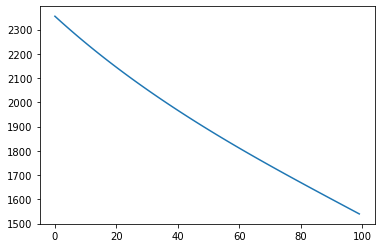

In [234]:
plt.plot(r)